 # 01b_Build a CALSPEC list of observable target from getCalspec package and generate sky trajectories and plot

- Author Sylvie Dagoret-Campagne
- Creation : August 22th 2023
- Update : August 23th 2023 : all bug corrected
- Update : August 24th 2023 : add UTC time to plots
- Update : August 29th 2023 : preselection fo target activated by a FLAG
- Update : August 29th 2023 : Correct a big bug on Longitide angle and ra selection
- Update : August 30th 2023 : DarkTimeIndex 
- update : December 17th 2024 : Prepare observation for January 6th 2025
- update : December 21th 2024 : set python = 3.13 in conda_py313
- update : December 22th 2024 : Suppress timezone and use true UTC
- update : January 06 2025 : conda_py313
- last update : May 20 2025 : conda_py313

## Ckeck on airmass.org : https://airmass.org/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.dates import (AutoDateLocator, YearLocator, MonthLocator,
                              DayLocator, WeekdayLocator, HourLocator,
                              MinuteLocator, SecondLocator, MicrosecondLocator,
                              RRuleLocator, rrulewrapper, MONTHLY,
                              MO, TU, WE, TH, FR, SA, SU, DateFormatter,
                              AutoDateFormatter, ConciseDateFormatter)

%matplotlib inline
import pandas as pd

In [2]:
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.coordinates import Angle
from astropy.time import Time, TimezoneInfo,TimeDelta
from astropy.coordinates import Longitude,Latitude

In [3]:
import datetime as dt
from datetime import datetime
import timezonefinder, pytz
from tzwhere import tzwhere
from calendar import monthrange
import calendar

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from astroquery.simbad import Simbad

In [6]:
# to view the list of VOTABLE
# Simbad.list_votable_fields()

In [7]:
Simbad.add_votable_fields('sptype')
Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(B)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(V)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(R)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(I)') # add the Vega unit Magnitude 
#Simbad.add_votable_fields('flux_unit(V)')
#Simbad.add_votable_fields('flux_unit(I)')
#Simbad.add_votable_fields('flux_system(V)')
#Simbad.add_votable_fields('flux_system(I)')
#Simbad.add_votable_fields('ubv')  # Johnson UBV system

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/131944641.py:1: DeprecationWarning: 'sptype' has been renamed 'sp_type'. You'll see it appearing with its new name in the output table
  Simbad.add_votable_fields('sptype')
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/131944641.py:2: DeprecationWarning: The notation 'flux(U)' is deprecated since 0.4.8 in favor of 'U'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/131944641.py:3: DeprecationWarning: The notation 'flux(B)' is deprecated since 0.4.8 in favor of 'B'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/si

In [8]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [9]:
def CalculateBounds(theta,thetamin,thetamax):
    """
    Handle the boundaries of angles
    
    parameters:
        theta : the input angle in degree to test
        thetamin: lower bound angle
        thetamax: upper bound angle
    """
    
    theta_min_angle = Longitude(thetamin,unit=u.degree)
    theta_max_angle = Longitude(thetamax,unit=u.degree)
    theta_angle = Longitude(theta,unit=u.degree)
    
    #print("longitude angles",theta_angle,theta_min_angle,theta_max_angle)
    
    wrap = 0
    
    if theta_min_angle.degree < theta_max_angle.degree:
        wrap = 360 * u.deg
    else:
        wrap = 180 * u.deg
        
    theta_min_angle.wrap_angle = wrap
    theta_max_angle.wrap_angle = wrap
    theta_angle.wrap_angle = wrap
       
    #print("wrap",wrap,"theta=",theta_angle,"theta_min=",theta_min_angle,"theta_max",theta_max_angle)
    return theta_angle.is_within_bounds(theta_min_angle,theta_max_angle)
    

## Configuration

### Specify the observation date

In [10]:
NYEAR=2025
NMONTH=6
NDAY=1

## Initialisation

### Location of sites

In [11]:
list_of_observation_sites = EarthLocation.get_site_names()

In [12]:
print(list_of_observation_sites)

['ALMA', 'AO', 'ARCA', 'ASKAP', 'ATA', 'ATST', 'Allen Telescope Array', 'Anderson Mesa', 'Anglo-Australian Observatory', 'Apache Point', 'Apache Point Observatory', 'Arecibo', 'Arecibo Observatory', 'Astroparticle Research with Cosmics in the Abyss', 'Atacama Large Millimeter Array', 'Australian Square Kilometre Array Pathfinder', 'BAO', 'BBSO', 'Beijing XingLong Observatory', 'Big Bear Solar Observatory', 'Black Moshannon Observatory', 'CAHA', 'CAHA', 'CHARA', 'CHIME', 'Canada-France-Hawaii Telescope', 'Canadian Hydrogen Intensity Mapping Experiment', 'Catalina Observatory', 'Catalina Observatory: 61 inch telescope', 'Centro Astronomico Hispano-Aleman, Almeria', 'Cerro Armazones Observatory', 'Cerro Pachon', 'Cerro Paranal', 'Cerro Tololo', 'Cerro Tololo Interamerican Observatory', 'Cima Ekar 182 cm Telescope', 'Cima Ekar Observing Station', 'DCT', 'DKIST', 'DRAO', 'DRAO 26m Telescope', 'Daniel K. Inouye Solar Telescope', 'Discovery Channel Telescope', 'Dominion Astrophysical Observat

#### Greenwitch Observatory

In [13]:
latitude_greenwitch = 51.476852*u.degree 
# There is a little shift between the prime meridian and the Greenwitch observatory
#longitude_greenwitch = -0.000500*u.degree
longitude_greenwitch = -0.00*u.degree
altitude_greenwitch = 68.0*u.m
site_Greenwitch = EarthLocation(lat=latitude_greenwitch, lon=longitude_greenwitch, height=altitude_greenwitch)

In [14]:
site_Greenwitch 

<EarthLocation (3980706.08142233, -0., 4966812.03170814) m>

In [15]:
tf = timezonefinder.TimezoneFinder()
timezone_greenwitch_str = tf.certain_timezone_at(lat=latitude_greenwitch/u.degree , lng=longitude_greenwitch/u.degree)
print(f"Time zone at Greenwitch Observatory: {timezone_greenwitch_str}")

Time zone at Greenwitch Observatory: Europe/London


In [16]:
# Not working (want to know where is the observatory relative to zone border)
tz_data = tf.get_geometry(tz_name=timezone_greenwitch_str)[0][0]
all_long,all_lat = np.array(tz_data)
min_longitude_tzgreen = all_long.min()
max_longitude_tzgreen = all_long.max()

In [17]:
print(f" Check longitude : {min_longitude_tzgreen} < {longitude_greenwitch} < {max_longitude_tzgreen}")

 Check longitude : -14.015517 < -0.0 deg < -13.360968


#### Rubin-LSST Observatory

In [18]:
LSSTNAME='Cerro Pachon'
site_LSST = EarthLocation.of_site(LSSTNAME)
longitude_lsst = site_LSST.lon
latitude_lsst = site_LSST.lat
altitude_lsst = site_LSST.height
site_LSST

<EarthLocation (1820193.06844603, -5208343.03427567, -3194842.50048343) m>

In [19]:
cerro_pachon = EarthLocation(lat = latitude_lsst, lon = longitude_lsst, height = altitude_lsst)
cerro_pachon 

<EarthLocation (1820193.06844603, -5208343.03427567, -3194842.50048343) m>

In [20]:
tf = timezonefinder.TimezoneFinder()
timezone_lsst_str = tf.certain_timezone_at(lat=latitude_lsst/u.degree , lng=longitude_lsst/u.degree)
print(f"Time zone at Rubin LSST Observatory: {timezone_lsst_str}")

Time zone at Rubin LSST Observatory: America/Santiago


In [21]:
# Not working (want to know where is the observatory relative to zone border)
tz_data = tf.get_geometry(tz_name=timezone_lsst_str)[0][0]
all_long,all_lat = np.array(tz_data)
min_longitude_tzlsst = all_long.min()
max_longitude_tzlsst = all_long.max()

In [22]:
print(f" Check longitude : {min_longitude_tzlsst} < {longitude_lsst} < {max_longitude_tzlsst}")

 Check longitude : -79.19552 < -70.7366833333333 deg < -78.5298


### UTC offset

- Quelle est l'offset number en UTC du chili
ChatGPT a dit :
Le Chili se situe normalement dans le fuseau horaire UTC-4 (Chili Standard Time, CLT). Cependant, il utilise également l’heure d’été (Chili Summer Time, CLST), qui est UTC-3.

Détail :
- UTC-4 (CLT) : heure standard, utilisée en hiver (approximativement d’avril à septembre).
- UTC-3 (CLST) : heure d’été, utilisée en été (approximativement de septembre à avril).

Actuellement (20 mai 2025) :
Le Chili est en heure d’hiver (CLT), donc l’offset UTC est -4.

#### UTC offset using longitude

In [23]:
longitude_offset = longitude_lsst - longitude_greenwitch
longitude_offset

<Angle -70.73668333 deg>

In [24]:
longitude_offset.hour

np.float64(-4.715778888888888)

In [25]:
#utcoffset_number = timezone.utcoffset(dt).total_seconds()/60./60.
utcoffset_number1 = longitude_offset.hour
print("The UTC offset in Chile is ",utcoffset_number1," hours")

The UTC offset in Chile is  -4.715778888888888  hours


In [26]:
utcoffset_number2  = (longitude_lsst * 24.0 / 360.0/u.deg)
utcoffset_number2 

<Quantity -4.71577889>

- Notice that this offset calculated above is in sidereal time not in solar time

#### UTC offset Using timezone

In [27]:
if timezone_lsst_str is None:
    print("Could not determine my time zone")
else:
    # Display the current time in that time zone
        
    timezone_lsst = pytz.timezone(timezone_lsst_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    utc_offset =  timezone_lsst.utcoffset(dt)
    
    print("\t - The UTC Time now %s" % dt)
    print(f"\t - the UTC offset in zone {timezone_lsst_str} is {utc_offset}")

	 - The UTC Time now 2025-05-20 14:13:31.125415
	 - the UTC offset in zone America/Santiago is -1 day, 20:00:00


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/3632194934.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  dt = datetime.utcnow()


In [28]:
# This is the offset that works with the sidereal time calculated after
utcoffset_number3 = timezone_lsst.utcoffset(dt).total_seconds()/60./60.
utcoffset_number3

-4.0

### Try to correct internally to the time zone

In [29]:
dt_corr = (longitude_offset.hour - np.floor(longitude_offset.hour))
dt_corr

np.float64(0.2842211111111119)

In [30]:
utcoffset_number4 = utcoffset_number3 - dt_corr

#### the TimezoneInfo object from astropy

- https://docs.astropy.org/en/stable/api/astropy.time.TimezoneInfo.html
- create the TimezoneInfo object required for sideral time

Have to choose among the four calculations :**utcoffset_number1, utcoffset_number2, utcoffset_number3, utcoffset_number4**

- Only utcoffset_number3 gives the correct sidereal time within 2 minutes

In [31]:
utcoffset_number = utcoffset_number3
tz_utc_minus_xx_hours = TimezoneInfo(utc_offset = utcoffset_number*u.hour)

In [109]:
utcoffset_number

-4.0

### Night of observation and local time

- creation of an observation date chosen very close to the local midnight from the chosen NYEAR,NMONTH,NDAY
- Note we provide the **tz_utc_minus_xx_hours** which provide the UTC offset of the site

In [32]:
# datetime at local midnight in the timezone of Chile by providing the right TimezoneInfo() object set at site Timezone
night_obs = datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight = datetime(NYEAR, NMONTH, NDAY, 23, 59,59,tzinfo = tz_utc_minus_xx_hours)
night_obs_midnight

datetime.datetime(2025, 6, 1, 23, 59, 59, tzinfo=<astropy.time.formats.TimezoneInfo object at 0x1605a5400>)

In [33]:
night_obs_str = night_obs.strftime("%Y-%m-%d %H:%M:%S")
print(f"Night of Observation : {night_obs_str}")

Night of Observation : 2025-06-01 00:00:00


In [34]:
#check the string of the date
night_obs_midnight_str = night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str
print(f"Midnight of Night of Observation : {night_obs_midnight_str}")

Midnight of Night of Observation : 2025-06-01 23:59:59


### Compute UTC and Sideral Time at local midnight

We check here that the offset in time between UTC and Chile time is 3 hours

##### TimezoneInfo object from astropy
https://docs.astropy.org/en/stable/api/astropy.time.TimezoneInfo.html

In [35]:
tz_utc = TimezoneInfo() 
print("\t - Local time in Santiago in (GMT-3) in winter : ",night_obs_midnight)
print("\t - Time in UTC at the Local Time above         : ",night_obs_midnight.astimezone(tz_utc))

	 - Local time in Santiago in (GMT-3) in winter :  2025-06-01 23:59:59-04:00
	 - Time in UTC at the Local Time above         :  2025-06-02 03:59:59+00:00


#### Sidereal time at LSST site 

- https://docs.astropy.org/en/stable/time/index.html
- we compute here the local sideral time at midnight local time
- we need to provide the utc offset  from the object TimezoneInfo required later to compute the local siteral time

#### Sidereal time and angle at local time midnight

- this calculation has been checked in Stellarium at Cerro Pachon for this observation date and time
- using utc_offset3 based on timezone info, I have only 2 minutes differences

In [36]:
# the sidereal time is constructed from 1) local clock wall time, 2) the UTC timezone 3) and the location of observation site on earth 
t_lsst = Time(night_obs_midnight.astimezone(tz_utc), scale='utc',location = site_LSST)
#t_sidereal_lsst = t_lsst.sidereal_time('apparent')  
t_sidereal_lsst = t_lsst.sidereal_time('mean')  
print("Sideral Time at LSST midnight:",t_sidereal_lsst)

Sideral Time at LSST midnight: 16h00m33.95919708s


#### The Sideral angle is measured from the meridian ( westward in north hemisphere)

In [37]:
print("Sidereal Time angle at LSST midnight:",Angle(t_sidereal_lsst).to(u.degree))
print("Sidereal Time angle at LSST midnight:",Angle(t_sidereal_lsst).degree)

Sidereal Time angle at LSST midnight: 240d08m29.38795614s
Sidereal Time angle at LSST midnight: 240.1414966544826


### get CALSPEC
Use the package getCalspec to work on CALSPEC object

https://github.com/LSSTDESC/getCalspec/blob/main/getCalspec/getCalspec.py

https://github.com/LSSTDESC/getCalspec/tree/main/getCalspec

In [38]:
# to get all Calspec data in one time in cache, write¶
from getCalspec.rebuild import rebuild_cache
# rebuild_cache()

In [39]:
# When the STSC webpage is updated, it might be necessary to rebuild the calspec_data/calspec.csv table and the cache:¶
from getCalspec.rebuild import rebuild_tables, rebuild_cache
#rebuild_tables()
#rebuild_cache()

### Retrieve all calspec

Try directly reading the table from getCalspec package. If not possible, read directly this table from the table stored in filename = "../../calspec_data/calspec.csv"

In [40]:
from getCalspec.getCalspec import getCalspecDataFrame

In [41]:
flag_getscalspec = False
try:
    df = getCalspecDataFrame()
    flag_getscalspec = True
except:
    filename = "../../calspec_data/calspec.csv"
    df = pd.read_csv(filename,index_col=0)  
finally:
    print(f">>>> getCalspec : {flag_getscalspec} <<<<<")
    print(df.head())   

>>>> getCalspec : True <<<<<
   Unnamed: 0 Star_name   Sp_T      V    B_V     Name     Model          STIS  \
0           0   109 VIR  A0III   3.73  -0.01   109vir  _mod_003     _stis_003   
1           1    10 LAC    O9V   4.88  -0.21    10lac  _mod_005     _stis_007   
2           2  16 CYG B    G3V   6.20   0.66   16cygb  _mod_004     _stis_004   
3           3    18 SCO    G2V   5.50   0.65    18sco  _mod_005     _stis_005   
4           4   1732526    A4V  12.53   0.12  1732526  _mod_005  _stisnic_007   

  Var_(%)            RA          Decl    Vr      PM    PM.1  \
0     NaN  14 46 14.925  +01 53 34.38  -6.1 -114.03  -22.13   
1   <0.23  22 39 15.679  +39 03 00.97 -10.0   -0.32   -5.46   
2   <0.21  19 41 51.973  +50 31 03.09 -27.7 -134.79 -162.49   
3     NaN  16 15 37.270  -08 22 09.98  11.9  232.16 -495.37   
4    1.40  17 32 52.630  +71 04 43.12   NaN    0.22   -2.71   

               Simbad_Name  Alt_Simbad_Name  Astroquery_Name Alt_Star_name  \
0                 HD130109 

### Preselection of targets

    HD185975 20:28:18 -87:28:19.9 type G3V, V=8.10
    HD14943 02:22:54 -51:05:31.7 type A5V, V=5.91
    HD38666 05:46:00 -32:18:23.2  type O9.5V, V=5.2
    HD60753 07:33:27 -50:35:03.3  type B3IV, V=6.7 
    HD146233 16:15:37 -08:22:10.0  type G2V, V=5.5

In [42]:
FLAG_PRESELECTION_TARGET = False
preselected_target_names = np.array(["HD185975","HD14943","HD38666","HD60753","HD146233"])

## Filter Obervable targets according RA and magnitude and culmination angle
$$
HA = LST - RA
$$

where $HA$ means Hour Angle, $LST$ means Local sidereal time and $RA$ means Right ascension
- $-6H<HA<+6H \longrightarrow  LST-6H <RA< LST+6H $ 
- Select the target which Right-Asccention is +/- 6 hours from the sideral time
- The culmination Hour angle at the meridian must not be less than -6H to + 6H

#### - Criteria on Margin Angle

- **Strange but I cannot have a larger margin : need to understand**

In [43]:
MarginAngle = Angle(6.0,u.hour)
MarginAngle

<Angle 6. hourangle>

$$
RA = LST - HA(margin\; Angle)
$$

In [44]:
#calculate tdege range of RA target to be visible within the MarginAngle
#ra_min = (t_sidereal_lsst - MarginAngle).degree
#ra_max = (t_sidereal_lsst + MarginAngle).degree
ra_min = Longitude((t_sidereal_lsst - MarginAngle).degree,unit=u.deg)
ra_max = Longitude((t_sidereal_lsst + MarginAngle).degree,unit=u.deg)

In [45]:
ra_min

<Longitude 150.14149665 deg>

In [46]:
ra_max

<Longitude 330.14149665 deg>

In [47]:
#ra_min_angle = Angle(ra_min,u.degree)
#ra_max_angle = Angle(ra_max,u.degree)
ra_min_angle = Longitude(ra_min,u.degree)
ra_max_angle = Longitude(ra_max,u.degree)
#ra_min_angle.wrap_angle = 180 * u.deg
#ra_max_angle.wrap_angle = 180 * u.deg

In [48]:
ra_min_angle.degree

np.float64(150.14149665448264)

In [49]:
ra_max_angle.degree

np.float64(330.14149665448264)

#### - Criteria on culmination angle

- The culmination angle is obtained when HA = 0, then RA = LST

In [50]:
culmin_angle_min = 40

#### - Criteria on magnitude in V

In [51]:
magLim = 12.

### Algo for the selection of the target wrt RA selection , culmination angle, 

In [52]:
latitude = latitude_lsst

all_flag_select = []

# numeric collections
all_ra_angles_deg = []
all_dec_angles_deg = []
all_altmax_angle_deg = []
all_zenithmin_angle_deg = []
all_magV = []

# loop on each entries in the df table to calculate angles
for index, row in df.iterrows(): 
    target_name = row["Star_name"]
    hd_name = row["HD_name"]
    
    # compute numeric values for ra-dec
    ra_angle = Longitude(row['RA'],unit = u.hour) # the RA angle is a string in Sexagesimal hours
    #ra_angle.wrap_angle = 180 * u.deg
    
    dec_angle = Angle(row["Decl"],unit = u.deg) # the dec angle is a string in degrees 

    
    # compute the culmination angle from the zenith angle
    # North hemisphere
    if latitude.deg >= 0:
        if dec_angle.deg >= latitude.deg:
            zenith_angle =   dec_angle - latitude
        else:
            zenith_angle = latitude - dec_angle
    # south hemisphere
    else:
        if dec_angle.deg < latitude.deg :
            zenith_angle =   latitude - dec_angle 
        else:
            zenith_angle =   dec_angle - latitude 
        
    culmination_angle = Angle(90.0, unit = u.deg) - zenith_angle

    
    # don't remember why I do this
    if (index !=12) and (index !=13) and (index!= 95):
        magV = float(row["V"])
    else:
        if index == 12:
            magV = 12.47
        elif index==13:
            magV = 13.80
        elif index == 95:
            magV = 17.01
            
             
    all_ra_angles_deg.append(ra_angle.degree)
    all_dec_angles_deg.append(dec_angle.degree)
    all_altmax_angle_deg.append(culmination_angle.degree) 
    all_zenithmin_angle_deg.append(zenith_angle.degree )
    all_magV.append(magV)
  
    # test on ra angle
    #flag1 = ra_angle.is_within_bounds(ra_min_angle,ra_max_angle)
    flag1 = CalculateBounds(ra_angle.degree,ra_min_angle.degree,ra_max_angle.degree)
    
    flag2 = (magV < magLim)
    flag3 = False
    
    # test on culmination angle
    if culmination_angle.degree > culmin_angle_min :
        flag3 = True
        
    
    flag = flag1 & flag2 & flag3
    
    if target_name == "HD185975":
        # keep polar star
        flag = True

    # test on preselected names
    if FLAG_PRESELECTION_TARGET:
        if target_name in preselected_target_names:
          
            if not flag:
                print(f"BE CAREFULL , a rejected target {target_name} is in Pre-Selection list, PLEASE CHECK")
            flag =True
        else:
            if flag:
                print(f"BE CAREFULL , a good target {target_name} is not in Pre-Selection list, PLEASE CHECK")
            flag = False
        
    
    if flag:
        print(f"{index}, {target_name} ({hd_name}), RA = {ra_angle.hour:.2f} , DEC = {dec_angle.degree:.2f} , RA-MIN-MAX = {ra_min_angle.deg:.1f}-{ra_max_angle.deg:.1f},zenith_angle = {zenith_angle.degree:.2f}  culmination angle = {culmination_angle.degree:.2f} , magV = {magV} , flag_select = {flag}")
   
    all_flag_select.append(flag)                

0, 109 VIR (HD130109), RA = 14.77 , DEC = 1.89 , RA-MIN-MAX = 150.1-330.1,zenith_angle = 32.13  culmination angle = 57.87 , magV = 3.73 , flag_select = True
3, 18 SCO (HD146233), RA = 16.26 , DEC = -8.37 , RA-MIN-MAX = 150.1-330.1,zenith_angle = 21.87  culmination angle = 68.13 , magV = 5.5 , flag_select = True
16, BD+02 3375 (nan), RA = 17.66 , DEC = 2.42 , RA-MIN-MAX = 150.1-330.1,zenith_angle = 32.66  culmination angle = 57.34 , magV = 9.93 , flag_select = True
17, BD-11 3759 (nan), RA = 14.57 , DEC = -12.52 , RA-MIN-MAX = 150.1-330.1,zenith_angle = 17.72  culmination angle = 72.28 , magV = 11.32 , flag_select = True
39, HD101452 (HD101452), RA = 11.67 , DEC = -39.15 , RA-MIN-MAX = 150.1-330.1,zenith_angle = 8.91  culmination angle = 81.09 , magV = 8.2 , flag_select = True
40, HD106252 (HD106252), RA = 12.22 , DEC = 10.04 , RA-MIN-MAX = 150.1-330.1,zenith_angle = 40.28  culmination angle = 49.72 , magV = 7.36 , flag_select = True
41, HD111980 (HD111980), RA = 12.89 , DEC = -18.52 , 

## Add calculated numerical values to the pandas table

In [53]:
df["ra_deg"] = all_ra_angles_deg
df["dec_deg"] = all_dec_angles_deg 
df["alt_max"] = all_altmax_angle_deg
df["zenith_min"] = all_zenithmin_angle_deg
df["magV"] = all_magV 

### Example for debug

In [54]:
cut = df["Star_name"] == "HD205905"

In [55]:
df[cut]

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV
58,58,HD205905,G2V,6.74,0.62,hd205905,_mod_007,_stis_009,0.26,21 39 10.151,-27 18 23.67,-17.0,384.1,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74


## Apply all selection cuts on RA, culmination and magnitude

In [56]:
df["select"] = all_flag_select
cut = df["select"] == True

t=df[cut]
NTargets=len(t)

In [57]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select
0,0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,NaN,14 46 14.925,+01 53 34.38,-6.1,-114.03,-22.13,HD130109,NaN,* 109 VIR,NaN,HD130109,221.562187,1.892883,57.866375,32.133625,3.73,True
3,3,18 SCO,G2V,5.50,0.65,18sco,_mod_005,_stis_005,NaN,16 15 37.270,-08 22 09.98,11.9,232.16,-495.37,HD146233,NaN,* 18 SCO,NaN,HD146233,243.905292,-8.369439,68.128697,21.871303,5.50,True
16,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True
17,17,BD-11 3759,M3.5V,11.32,1.60,bd11d3759,NaN,_stis_003,NaN,14 34 16.812,-12 31 10.42,-1.0,-355.04,593.22,NaN,NaN,BD-11 3759,NaN,NaN,218.570050,-12.519561,72.278819,17.721181,11.32,True
39,39,HD101452,A2/3,8.20,-0.36,hd101452,_mod_003,_stis_003,<0.09,11 40 13.651,-39 08 47.67,NaN,-34.17,-20.98,NaN,NaN,HD 101452,NaN,HD101452,175.056879,-39.146575,81.094167,8.905833,8.20,True
40,40,HD106252,G0,7.36,0.64,hd106252,_mod_006,_stis_008,NaN,12 13 29.510,+10 02 29.89,16.0,22.86,-280.01,NaN,NaN,HD 106252,NaN,HD106252,183.372958,10.041636,49.717622,40.282378,7.36,True
41,41,HD111980,F7V,8.38,0.53,hd111980,_mod_003,_stis_006,NaN,12 53 15.053,-18 31 20.01,155.0,299.49,-796.09,NaN,NaN,HD 111980,NaN,HD111980,193.312721,-18.522225,78.281483,11.718517,8.38,True
42,42,HD115169,G3V,9.20,0.69,hd115169,_mod_003,_stis_003,<0.11,13 15 47.388,-29 30 21.18,21.2,-110.57,-82.09,NaN,NaN,HD 115169,NaN,HD115169,198.947450,-29.505883,89.265142,0.734858,9.20,True
45,45,HD142331,G5V,8.75,0.64,hd142331,_mod_005,_stis_005,NaN,15 54 19.788,-08 34 49.37,-70.8,-105.98,-23.73,NaN,NaN,HD 142331,NaN,HD142331,238.582450,-8.580381,68.339639,21.660361,8.75,True
49,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True


### Must reindex the table

In [58]:
t = t.reset_index(drop=True)

In [59]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select
0,0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,NaN,14 46 14.925,+01 53 34.38,-6.1,-114.03,-22.13,HD130109,NaN,* 109 VIR,NaN,HD130109,221.562187,1.892883,57.866375,32.133625,3.73,True
1,3,18 SCO,G2V,5.50,0.65,18sco,_mod_005,_stis_005,NaN,16 15 37.270,-08 22 09.98,11.9,232.16,-495.37,HD146233,NaN,* 18 SCO,NaN,HD146233,243.905292,-8.369439,68.128697,21.871303,5.50,True
2,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True
3,17,BD-11 3759,M3.5V,11.32,1.60,bd11d3759,NaN,_stis_003,NaN,14 34 16.812,-12 31 10.42,-1.0,-355.04,593.22,NaN,NaN,BD-11 3759,NaN,NaN,218.570050,-12.519561,72.278819,17.721181,11.32,True
4,39,HD101452,A2/3,8.20,-0.36,hd101452,_mod_003,_stis_003,<0.09,11 40 13.651,-39 08 47.67,NaN,-34.17,-20.98,NaN,NaN,HD 101452,NaN,HD101452,175.056879,-39.146575,81.094167,8.905833,8.20,True
5,40,HD106252,G0,7.36,0.64,hd106252,_mod_006,_stis_008,NaN,12 13 29.510,+10 02 29.89,16.0,22.86,-280.01,NaN,NaN,HD 106252,NaN,HD106252,183.372958,10.041636,49.717622,40.282378,7.36,True
6,41,HD111980,F7V,8.38,0.53,hd111980,_mod_003,_stis_006,NaN,12 53 15.053,-18 31 20.01,155.0,299.49,-796.09,NaN,NaN,HD 111980,NaN,HD111980,193.312721,-18.522225,78.281483,11.718517,8.38,True
7,42,HD115169,G3V,9.20,0.69,hd115169,_mod_003,_stis_003,<0.11,13 15 47.388,-29 30 21.18,21.2,-110.57,-82.09,NaN,NaN,HD 115169,NaN,HD115169,198.947450,-29.505883,89.265142,0.734858,9.20,True
8,45,HD142331,G5V,8.75,0.64,hd142331,_mod_005,_stis_005,NaN,15 54 19.788,-08 34 49.37,-70.8,-105.98,-23.73,NaN,NaN,HD 142331,NaN,HD142331,238.582450,-8.580381,68.339639,21.660361,8.75,True
9,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True


In [60]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTargets)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTargets), alpha=1)

## Compute Target location before computing their sky trajectory

In [61]:
all_target_names = t["Astroquery_Name"]
print("order in selected target location")
print(all_target_names)
selected_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]

order in selected target location
0       * 109 VIR
1       *  18 SCO
2     BD+02  3375
3     BD-11  3759
4       HD 101452
5       HD 106252
6       HD 111980
7       HD 115169
8       HD 142331
9       HD 160617
10      HD 167060
11      HD 185975
12      HD 200654
13      HD 205905
Name: Astroquery_Name, dtype: object


In [62]:
all_ra_astroquery=[]
all_dec_astroquery=[]
for target_loc in selected_target_locations:
    all_ra_astroquery.append(target_loc.ra)
    all_dec_astroquery.append(target_loc.dec)

## Compute target tag

- the legend in the plot

In [63]:
all_target_simbadnames = t["Star_name"]
all_Vmag = []
all_types = []
all_target_tagnames = []
for idx, target_name in enumerate(all_target_simbadnames):
    flag_simbad = False
    try:
        result_table = Simbad.query_object(target_name)
        all_Vmag.append(result_table['FLUX_V'][0])
        all_types.append(result_table['SP_TYPE'][0])
        
        row = t.iloc[idx]
        tagname =  target_name + ", m = " + str(result_table['FLUX_V'][0]) + ", B-V = "+ row["B_V"]  + " (" + result_table['SP_TYPE'][0] +")" 
        flag_simbad = True
    except:
        row = t.iloc[idx]
        tagname = row["Name"] + ", B-V="+ row["B_V"]  + ", m= " + row["V"]
    finally:
        
        print(f"{idx}) {target_name} ::{tagname} :: simbad : {flag_simbad}")
        all_target_tagnames.append(tagname)

0) 109 VIR ::109vir, B-V=-0.01, m= 3.73 :: simbad : False
1) 18 SCO ::18sco, B-V=0.65, m= 5.50 :: simbad : False
2) BD+02 3375 ::bd02d3375, B-V=0.45, m= 9.93 :: simbad : False
3) BD-11 3759 ::bd11d3759, B-V=1.60, m= 11.32 :: simbad : False
4) HD101452 ::hd101452, B-V=-0.36, m= 8.20 :: simbad : False
5) HD106252 ::hd106252, B-V=0.64, m= 7.36 :: simbad : False
6) HD111980 ::hd111980, B-V=0.53, m= 8.38 :: simbad : False
7) HD115169 ::hd115169, B-V=0.69, m= 9.20 :: simbad : False
8) HD142331 ::hd142331, B-V=0.64, m= 8.75 :: simbad : False
9) HD160617 ::hd160617, B-V=0.45, m= 8.73 :: simbad : False
10) HD167060 ::hd167060, B-V=0.64, m= 8.92 :: simbad : False
11) HD185975 ::hd185975, B-V=0.68, m= 8.10 :: simbad : False
12) HD200654 ::hd200654, B-V=0.63, m= 9.11 :: simbad : False
13) HD205905 ::hd205905, B-V=0.62, m= 6.74 :: simbad : False


In [64]:
result_table

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,sp_type,U,B,V,R,I,matched_id
,deg,deg,mas,mas,deg,,,,,,,,,
object,float64,float64,float32,float32,int16,str1,object,object,float64,float64,float64,float64,float64,object
HD 205905,324.7922956298637,-27.306572956486942,0.0215,0.0169,90,O,2020yCat.1350....0G,G1.5IV-V,--,7.360000133514404,6.739999771118164,--,--,HD 205905


In [65]:
all_target_tagnames

['109vir, B-V=-0.01, m= 3.73',
 '18sco, B-V=0.65, m= 5.50',
 'bd02d3375, B-V=0.45, m= 9.93',
 'bd11d3759, B-V=1.60, m= 11.32',
 'hd101452, B-V=-0.36, m= 8.20',
 'hd106252, B-V=0.64, m= 7.36',
 'hd111980, B-V=0.53, m= 8.38',
 'hd115169, B-V=0.69, m= 9.20',
 'hd142331, B-V=0.64, m= 8.75',
 'hd160617, B-V=0.45, m= 8.73',
 'hd167060, B-V=0.64, m= 8.92',
 'hd185975, B-V=0.68, m= 8.10',
 'hd200654, B-V=0.63, m= 9.11',
 'hd205905, B-V=0.62, m= 6.74']

In [66]:
t["tag"] = all_target_tagnames

# Astronomical in Observation frame for each selected target

## Initialisation 

In [67]:
utcoffset_number

-4.0

In [68]:
night_obs_midnight_str

'2025-06-01 23:59:59'

In [69]:
# Greenwitch time at local midnight time
midnight_utc = Time(night_obs_midnight_str) - utcoffset_number*u.hour
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
sideral_times = Angle(t_sidereal_lsst) + Angle(delta_midnight)

# utc times around local midnight
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

In [70]:
times_evening_to_morning_datetime = times_evening_to_morning.to_datetime()

## Sun frame

In [71]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

## Moon frame

In [72]:
# Old version in conda_py310
#from astropy.coordinates import get_moon
#moon_evening_to_morning = get_moon(times_evening_to_morning)
#moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

In [73]:
from astropy import coordinates

### Get moon ephemerides
- Checked sky trajectory at https://airmass.org/

In [74]:
moon_evening_to_morning = coordinates.get_body("moon",times_evening_to_morning,location=site_LSST)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

## Targets Frame

In [75]:
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  selected_target_locations ]

## Distance to the moon

In [76]:
all_target_distancetomoon_evening_to_morning = [] 

num_target=0
for idx,targetcoordinateseries in enumerate(all_target_altazs_evening_to_morning): 
    N_coord = len(targetcoordinateseries)
    idx_coord = 0
    all_distances_sep = []
    for idx_coord in range(N_coord):
        distance_sep=targetcoordinateseries[idx_coord].separation(moonaltazs_evening_to_morning[idx_coord])
        all_distances_sep.append(distance_sep.degree)
    all_distances_sep= np.array(all_distances_sep)
    all_distances_sep_min = all_distances_sep.min()
    all_target_distancetomoon_evening_to_morning.append(all_distances_sep_min) 
    all_target_tagnames[idx] += f", d_m = {all_distances_sep_min:.0f}°"
    num_target+=1

In [77]:
all_target_tagnames

['109vir, B-V=-0.01, m= 3.73, d_m = 62°',
 '18sco, B-V=0.65, m= 5.50, d_m = 86°',
 'bd02d3375, B-V=0.45, m= 9.93, d_m = 105°',
 'bd11d3759, B-V=1.60, m= 11.32, d_m = 63°',
 'hd101452, B-V=-0.36, m= 8.20, d_m = 52°',
 'hd106252, B-V=0.64, m= 7.36, d_m = 23°',
 'hd111980, B-V=0.53, m= 8.38, d_m = 44°',
 'hd115169, B-V=0.69, m= 9.20, d_m = 55°',
 'hd142331, B-V=0.64, m= 8.75, d_m = 81°',
 'hd160617, B-V=0.45, m= 8.73, d_m = 109°',
 'hd167060, B-V=0.64, m= 8.92, d_m = 111°',
 'hd185975, B-V=0.68, m= 8.10, d_m = 103°',
 'hd200654, B-V=0.63, m= 9.11, d_m = 137°',
 'hd205905, B-V=0.62, m= 6.74, d_m = 159°']

### Update target tag

In [78]:
t["tag"] = all_target_tagnames

In [79]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select,tag
0,0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,NaN,14 46 14.925,+01 53 34.38,-6.1,-114.03,-22.13,HD130109,NaN,* 109 VIR,NaN,HD130109,221.562187,1.892883,57.866375,32.133625,3.73,True,"109vir, B-V=-0.01, m= 3.73, d_m = 62°"
1,3,18 SCO,G2V,5.50,0.65,18sco,_mod_005,_stis_005,NaN,16 15 37.270,-08 22 09.98,11.9,232.16,-495.37,HD146233,NaN,* 18 SCO,NaN,HD146233,243.905292,-8.369439,68.128697,21.871303,5.50,True,"18sco, B-V=0.65, m= 5.50, d_m = 86°"
2,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True,"bd02d3375, B-V=0.45, m= 9.93, d_m = 105°"
3,17,BD-11 3759,M3.5V,11.32,1.60,bd11d3759,NaN,_stis_003,NaN,14 34 16.812,-12 31 10.42,-1.0,-355.04,593.22,NaN,NaN,BD-11 3759,NaN,NaN,218.570050,-12.519561,72.278819,17.721181,11.32,True,"bd11d3759, B-V=1.60, m= 11.32, d_m = 63°"
4,39,HD101452,A2/3,8.20,-0.36,hd101452,_mod_003,_stis_003,<0.09,11 40 13.651,-39 08 47.67,NaN,-34.17,-20.98,NaN,NaN,HD 101452,NaN,HD101452,175.056879,-39.146575,81.094167,8.905833,8.20,True,"hd101452, B-V=-0.36, m= 8.20, d_m = 52°"
5,40,HD106252,G0,7.36,0.64,hd106252,_mod_006,_stis_008,NaN,12 13 29.510,+10 02 29.89,16.0,22.86,-280.01,NaN,NaN,HD 106252,NaN,HD106252,183.372958,10.041636,49.717622,40.282378,7.36,True,"hd106252, B-V=0.64, m= 7.36, d_m = 23°"
6,41,HD111980,F7V,8.38,0.53,hd111980,_mod_003,_stis_006,NaN,12 53 15.053,-18 31 20.01,155.0,299.49,-796.09,NaN,NaN,HD 111980,NaN,HD111980,193.312721,-18.522225,78.281483,11.718517,8.38,True,"hd111980, B-V=0.53, m= 8.38, d_m = 44°"
7,42,HD115169,G3V,9.20,0.69,hd115169,_mod_003,_stis_003,<0.11,13 15 47.388,-29 30 21.18,21.2,-110.57,-82.09,NaN,NaN,HD 115169,NaN,HD115169,198.947450,-29.505883,89.265142,0.734858,9.20,True,"hd115169, B-V=0.69, m= 9.20, d_m = 55°"
8,45,HD142331,G5V,8.75,0.64,hd142331,_mod_005,_stis_005,NaN,15 54 19.788,-08 34 49.37,-70.8,-105.98,-23.73,NaN,NaN,HD 142331,NaN,HD142331,238.582450,-8.580381,68.339639,21.660361,8.75,True,"hd142331, B-V=0.64, m= 8.75, d_m = 81°"
9,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True,"hd160617, B-V=0.45, m= 8.73, d_m = 109°"


## Sort target according increasing max culminating time

In [80]:
all_timemax=np.zeros(NTargets)
all_altitudesmax=np.zeros(NTargets)
for idx in np.arange(NTargets):
    altitudes=all_target_altazs_evening_to_morning[idx].alt
    idx_max=np.where(altitudes==altitudes.max())[0][0]
    all_timemax[idx]=delta_midnight[idx_max].value
    all_altitudesmax[idx]=altitudes.max().degree

In [81]:
all_altitudesmax

array([57.9744601 , 68.19370747, 57.35807974, 72.39215316, 80.94874577,
       49.85897185, 78.42202908, 89.3841206 , 68.41614838, 79.90640424,
       58.54262066, 32.85935594, 70.38137929, 86.94879744])

In [82]:
t["tmax"] = all_timemax

In [83]:
all_timemax

array([-1.21321321,  0.27627628,  1.66966967, -1.40540541, -4.31231231,
       -3.75975976, -3.08708709, -2.72672673, -0.08408408,  1.71771772,
        2.31831832,  4.64864865,  5.10510511,  5.65765766])

In [84]:
rank = np.argsort(all_timemax)
rank

array([ 4,  5,  6,  7,  3,  0,  8,  1,  2,  9, 10, 11, 12, 13])

In [85]:
rankinv = np.argsort(rank)
rankinv

array([ 5,  7,  8,  4,  0,  1,  2,  3,  6,  9, 10, 11, 12, 13])

In [86]:
#t.index[rank]

In [87]:
t["rank_tmax"] = rankinv # rank in time
t["rank_num"] = np.arange(NTargets) # rank in original table

In [88]:
#t = t.sort_values(by = ['tmax'])

### Must reindex dataframe for loop on targets (in sorting order)

In [89]:
#t.reset_index(inplace=True)

In [90]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select,tag,tmax,rank_tmax,rank_num
0,0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,NaN,14 46 14.925,+01 53 34.38,-6.1,-114.03,-22.13,HD130109,NaN,* 109 VIR,NaN,HD130109,221.562187,1.892883,57.866375,32.133625,3.73,True,"109vir, B-V=-0.01, m= 3.73, d_m = 62°",-1.213213,5,0
1,3,18 SCO,G2V,5.50,0.65,18sco,_mod_005,_stis_005,NaN,16 15 37.270,-08 22 09.98,11.9,232.16,-495.37,HD146233,NaN,* 18 SCO,NaN,HD146233,243.905292,-8.369439,68.128697,21.871303,5.50,True,"18sco, B-V=0.65, m= 5.50, d_m = 86°",0.276276,7,1
2,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True,"bd02d3375, B-V=0.45, m= 9.93, d_m = 105°",1.669670,8,2
3,17,BD-11 3759,M3.5V,11.32,1.60,bd11d3759,NaN,_stis_003,NaN,14 34 16.812,-12 31 10.42,-1.0,-355.04,593.22,NaN,NaN,BD-11 3759,NaN,NaN,218.570050,-12.519561,72.278819,17.721181,11.32,True,"bd11d3759, B-V=1.60, m= 11.32, d_m = 63°",-1.405405,4,3
4,39,HD101452,A2/3,8.20,-0.36,hd101452,_mod_003,_stis_003,<0.09,11 40 13.651,-39 08 47.67,NaN,-34.17,-20.98,NaN,NaN,HD 101452,NaN,HD101452,175.056879,-39.146575,81.094167,8.905833,8.20,True,"hd101452, B-V=-0.36, m= 8.20, d_m = 52°",-4.312312,0,4
5,40,HD106252,G0,7.36,0.64,hd106252,_mod_006,_stis_008,NaN,12 13 29.510,+10 02 29.89,16.0,22.86,-280.01,NaN,NaN,HD 106252,NaN,HD106252,183.372958,10.041636,49.717622,40.282378,7.36,True,"hd106252, B-V=0.64, m= 7.36, d_m = 23°",-3.759760,1,5
6,41,HD111980,F7V,8.38,0.53,hd111980,_mod_003,_stis_006,NaN,12 53 15.053,-18 31 20.01,155.0,299.49,-796.09,NaN,NaN,HD 111980,NaN,HD111980,193.312721,-18.522225,78.281483,11.718517,8.38,True,"hd111980, B-V=0.53, m= 8.38, d_m = 44°",-3.087087,2,6
7,42,HD115169,G3V,9.20,0.69,hd115169,_mod_003,_stis_003,<0.11,13 15 47.388,-29 30 21.18,21.2,-110.57,-82.09,NaN,NaN,HD 115169,NaN,HD115169,198.947450,-29.505883,89.265142,0.734858,9.20,True,"hd115169, B-V=0.69, m= 9.20, d_m = 55°",-2.726727,3,7
8,45,HD142331,G5V,8.75,0.64,hd142331,_mod_005,_stis_005,NaN,15 54 19.788,-08 34 49.37,-70.8,-105.98,-23.73,NaN,NaN,HD 142331,NaN,HD142331,238.582450,-8.580381,68.339639,21.660361,8.75,True,"hd142331, B-V=0.64, m= 8.75, d_m = 81°",-0.084084,6,8
9,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True,"hd160617, B-V=0.45, m= 8.73, d_m = 109°",1.717718,9,9


# Plot

In [91]:
all_target_names = t["Star_name"].values
all_target_names

array(['109 VIR', '18 SCO', 'BD+02 3375', 'BD-11 3759', 'HD101452',
       'HD106252', 'HD111980', 'HD115169', 'HD142331', 'HD160617',
       'HD167060', 'HD185975', 'HD200654', 'HD205905'], dtype=object)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/576793053.py:91: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/576793053.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


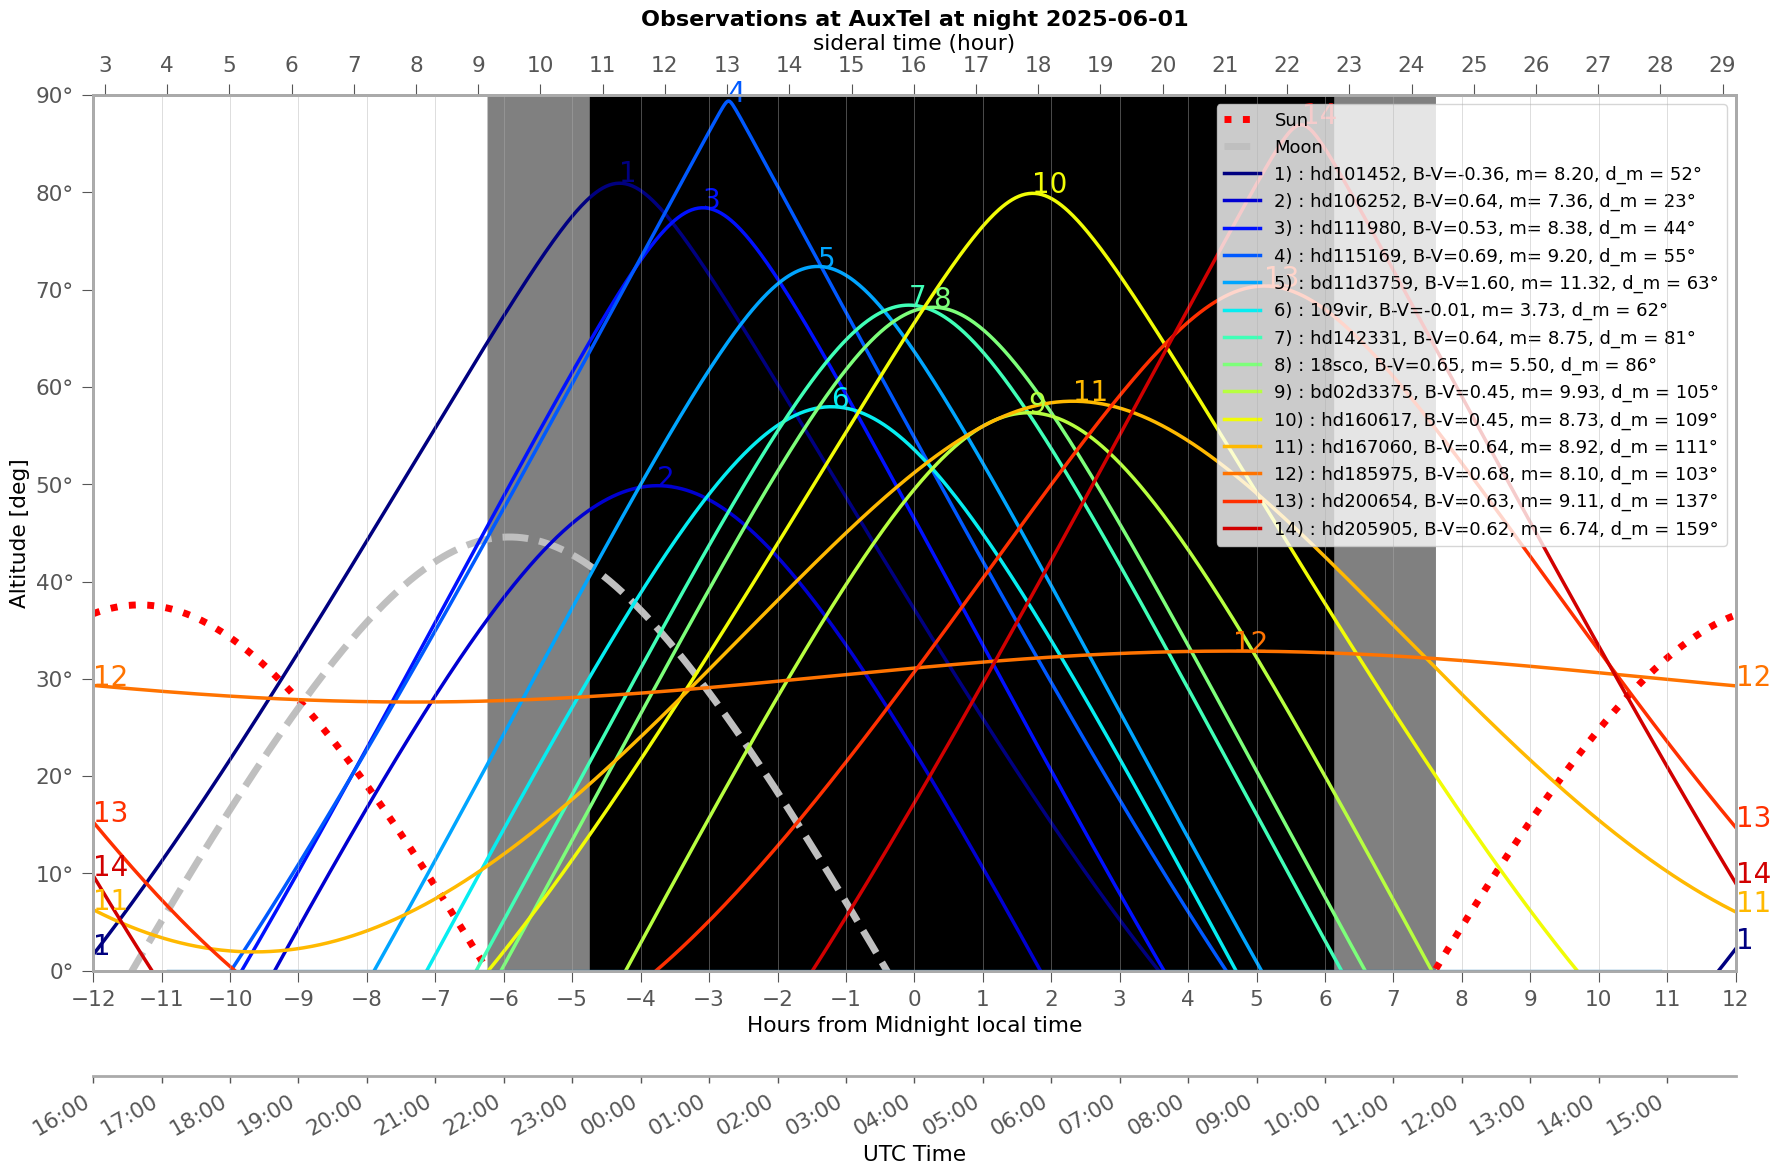

In [92]:
fig = plt.figure(figsize=(18,12),layout="constrained")


# First Axis : target sky trajectories
# ====================================
ax=fig.add_subplot(1,1,1)

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)
#for label in ax.get_xticklabels(which='major'):
#    label.set(rotation=30, horizontalalignment='right')


# second horizontal axis : Sideral time axis
# ==========================================
ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)

# third horizontal axis : UTC time axis
# =====================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
#fmt = '%m/%d %H:%M'
fmt = '%H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])



ax3.tick_params(which='major', width=1.00, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
#plt.gcf().autofmt_xdate()  # orient date labels at a slant
# slant for this axis
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax3.set_xlabel("UTC Time")

if FLAG_PRESELECTION_TARGET: 
    figname="AuxtelStarAlt_preselectedcalspec{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)
else:
    figname="AuxtelStarAlt_visiblecalspec{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.tight_layout()
plt.savefig(figname)

plt.show()

# To plot in staralt

https://www.ing.iac.es//Astronomy/telescopes/wht/catformat.html

In [93]:
t_staralt = t[["Star_name","RA","Decl","rank_tmax"]]
t_staralt["equinox"] = np.full(NTargets,"J2000")
t_staralt = t_staralt.sort_values(by = ['rank_tmax'])
t_staralt = t_staralt.drop(['rank_tmax'], axis=1)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/2260111632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_staralt["equinox"] = np.full(NTargets,"J2000")


In [94]:
t_staralt

,Star_name,RA,Decl,equinox
4,HD101452,11 40 13.651,-39 08 47.67,J2000
5,HD106252,12 13 29.510,+10 02 29.89,J2000
6,HD111980,12 53 15.053,-18 31 20.01,J2000
7,HD115169,13 15 47.388,-29 30 21.18,J2000
3,BD-11 3759,14 34 16.812,-12 31 10.42,J2000
0,109 VIR,14 46 14.925,+01 53 34.38,J2000
8,HD142331,15 54 19.788,-08 34 49.37,J2000
1,18 SCO,16 15 37.270,-08 22 09.98,J2000
2,BD+02 3375,17 39 45.595,+02 24 59.61,J2000
9,HD160617,17 42 49.324,-40 19 15.51,J2000


In [95]:
t_staralt.to_csv("staralt.csv",index=False,header=False, sep = " ")

In [96]:
! cat staralt.csv

HD101452 "11 40 13.651" "-39 08 47.67" J2000
HD106252 "12 13 29.510" "+10 02 29.89" J2000
HD111980 "12 53 15.053" "-18 31 20.01" J2000
HD115169 "13 15 47.388" "-29 30 21.18" J2000
"BD-11 3759" "14 34 16.812" "-12 31 10.42" J2000
"109 VIR" "14 46 14.925" "+01 53 34.38" J2000
HD142331 "15 54 19.788" "-08 34 49.37" J2000
"18 SCO" "16 15 37.270" "-08 22 09.98" J2000
"BD+02 3375" "17 39 45.595" "+02 24 59.61" J2000
HD160617 "17 42 49.324" "-40 19 15.51" J2000
HD167060 "18 17 44.143" "-61 42 31.62" J2000
HD185975 "20 28 18.740" "-87 28 19.94" J2000
HD200654 "21 06 34.751" "-49 57 50.28" J2000
HD205905 "21 39 10.151" "-27 18 23.67" J2000


# Spheric plot

### Looking toward local meridian, toward the north
- star rise from east 
- star set at west
- south pole is 30 degree above horizon

### Looking toward the south pole
- star rotate clockwise around the pole

### Dans l’hémisphère sud, les étoiles tournent autour du pôle Sud céleste dans le sens des aiguilles d’une montre.
Explication rapide :
- Dans l’hémisphère nord, les étoiles tournent autour du pôle Nord céleste dans le sens inverse des aiguilles d’une montre.
- Dans l’hémisphère sud, c’est l’inverse : autour du pôle Sud céleste, le mouvement apparent des étoiles est horaire, donc dans le sens des aiguilles d’une montre.
Si tu observes le ciel depuis l’hémisphère sud, par exemple en regardant vers le pôle Sud céleste (près de l’étoile Sigma Octantis), les étoiles sembleront tourner dans ce sens.

In [97]:
def makePolarPlot(azimuthsInDegrees, zenithAngles, marker=".",ax=None,
                       title=None, color=None, objName=None,lw=0.5):
    if ax==None:
        _ = plt.figure(figsize=(20, 10))
        ax = plt.subplot(111, polar=True)
        
    ax.plot([a*np.pi/180 for a in azimuthsInDegrees], zenithAngles, marker, c=color, label=objName,lw=lw)
    if title:
        ax.set_title(title, va='bottom')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(0, 90)
    return ax

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/630588586.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])


Text(0.5, 1.0, 'Observations at AuxTel at night 2025-06-01')

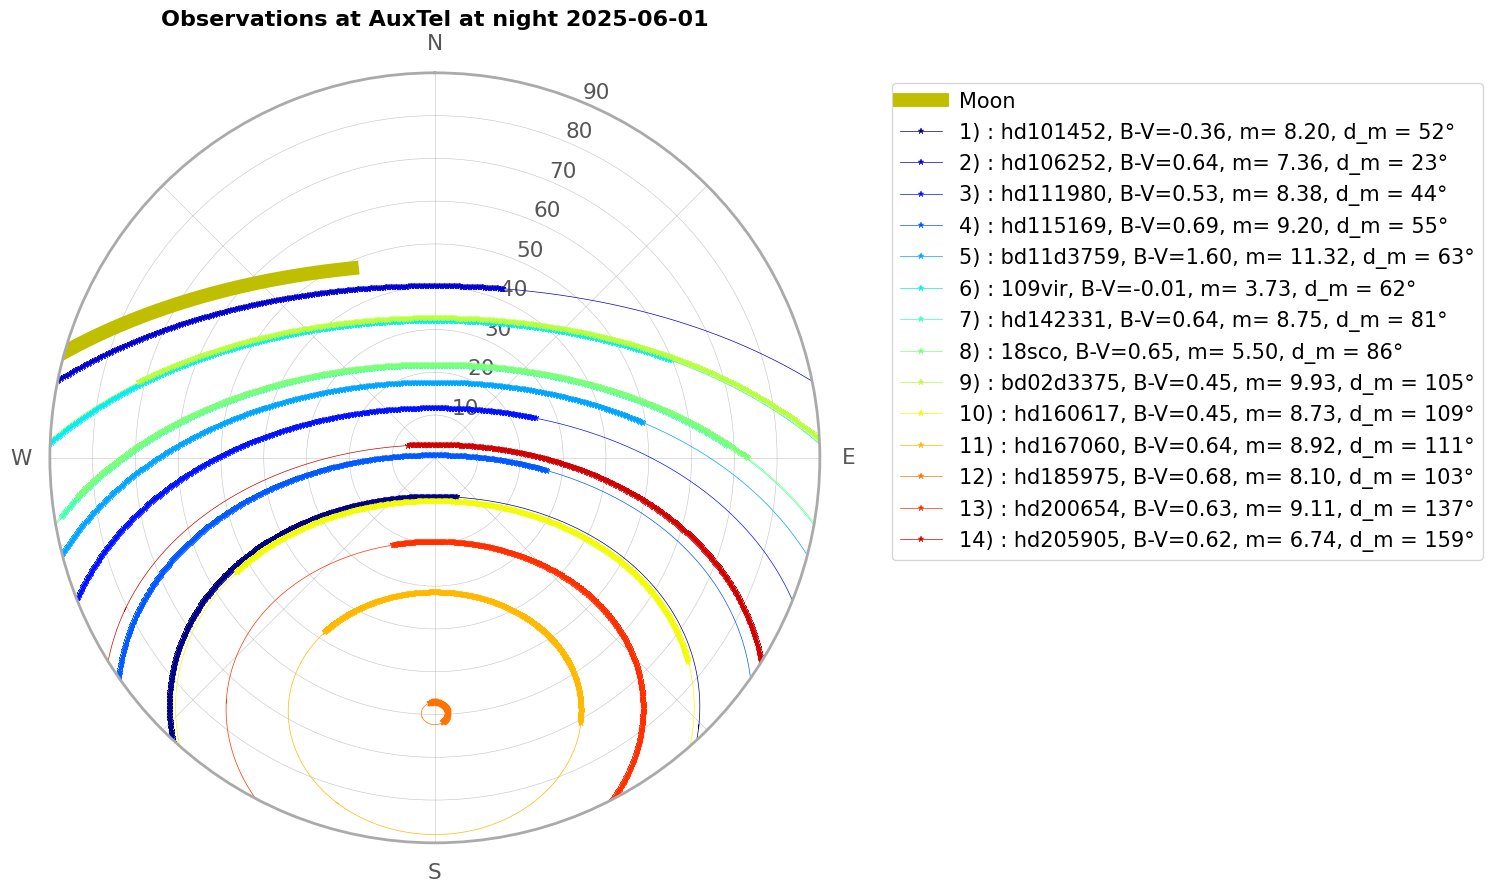

In [98]:
_ = plt.figure(figsize=(20, 10))

ax = plt.subplot(111, polar=True)


darkTimeIndex=[sunaltazs_evening_to_morning.alt < -18*u.deg][0]

# compute zenith and azimuth angles
moon_azimuthsInDegrees = Angle(moonaltazs_evening_to_morning.az).deg
moon_zenithAngles = Angle(moonaltazs_evening_to_morning.zen).deg

#ax=makePolarPlot(moon_azimuthsInDegrees, moon_zenithAngles,ax=ax, marker="--",color="y", title = None, lw=1)

moon_azimuthsInDegreesNight=moon_azimuthsInDegrees[darkTimeIndex]
moon_zenithAnglesNight=moon_zenithAngles[darkTimeIndex]
ax=makePolarPlot(moon_azimuthsInDegreesNight, moon_zenithAnglesNight,ax=ax ,marker="*-",title=None, color = "y",objName="Moon",lw=10)

    
# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
    
    
    
    # compute zenith and azimuth angles
    azimuthsInDegrees=Angle(all_target_altazs_evening_to_morning[rank_num].az).deg
    zenithAngles = Angle(all_target_altazs_evening_to_morning[rank_num].zen).deg
    
    ax=makePolarPlot(azimuthsInDegrees, zenithAngles,ax=ax, marker="-",title=None, color=all_colors[index], lw=0.5)
    
    azimuthsInDegreesNight=azimuthsInDegrees[darkTimeIndex]
    zenithAnglesNight=zenithAngles[darkTimeIndex]
    ax=makePolarPlot(azimuthsInDegreesNight, zenithAnglesNight,ax=ax ,marker="*-",title=None, color=all_colors[index],objName=label,lw=0.5)
    
    thex=zenithAnglesNight[0]*np.sin( (azimuthsInDegreesNight[0]) *np.pi/180.)
    they=zenithAnglesNight[0]*np.cos( (azimuthsInDegreesNight[0])*np.pi/180.)
   
    #plt.text(thex, they,f'{rank}',color=all_colors[rank],fontsize=20)
    
 
ax.legend(bbox_to_anchor=(1.08, 1), prop={'size': 15}, loc='upper left')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)

# Spectra

In [99]:
from getCalspec.getCalspec import *

In [100]:
plt.rcParams["figure.figsize"]=(8,4)

In [101]:
NTargets

14

In [102]:
ncols = 2

if NTargets % ncols == 0:
    nrows = NTargets//ncols+1
else:
    nrows = int(np.floor(NTargets/ncols))+1

In [103]:
nrows

8

In [104]:
XMIN = 300.
XMAX = 1100.

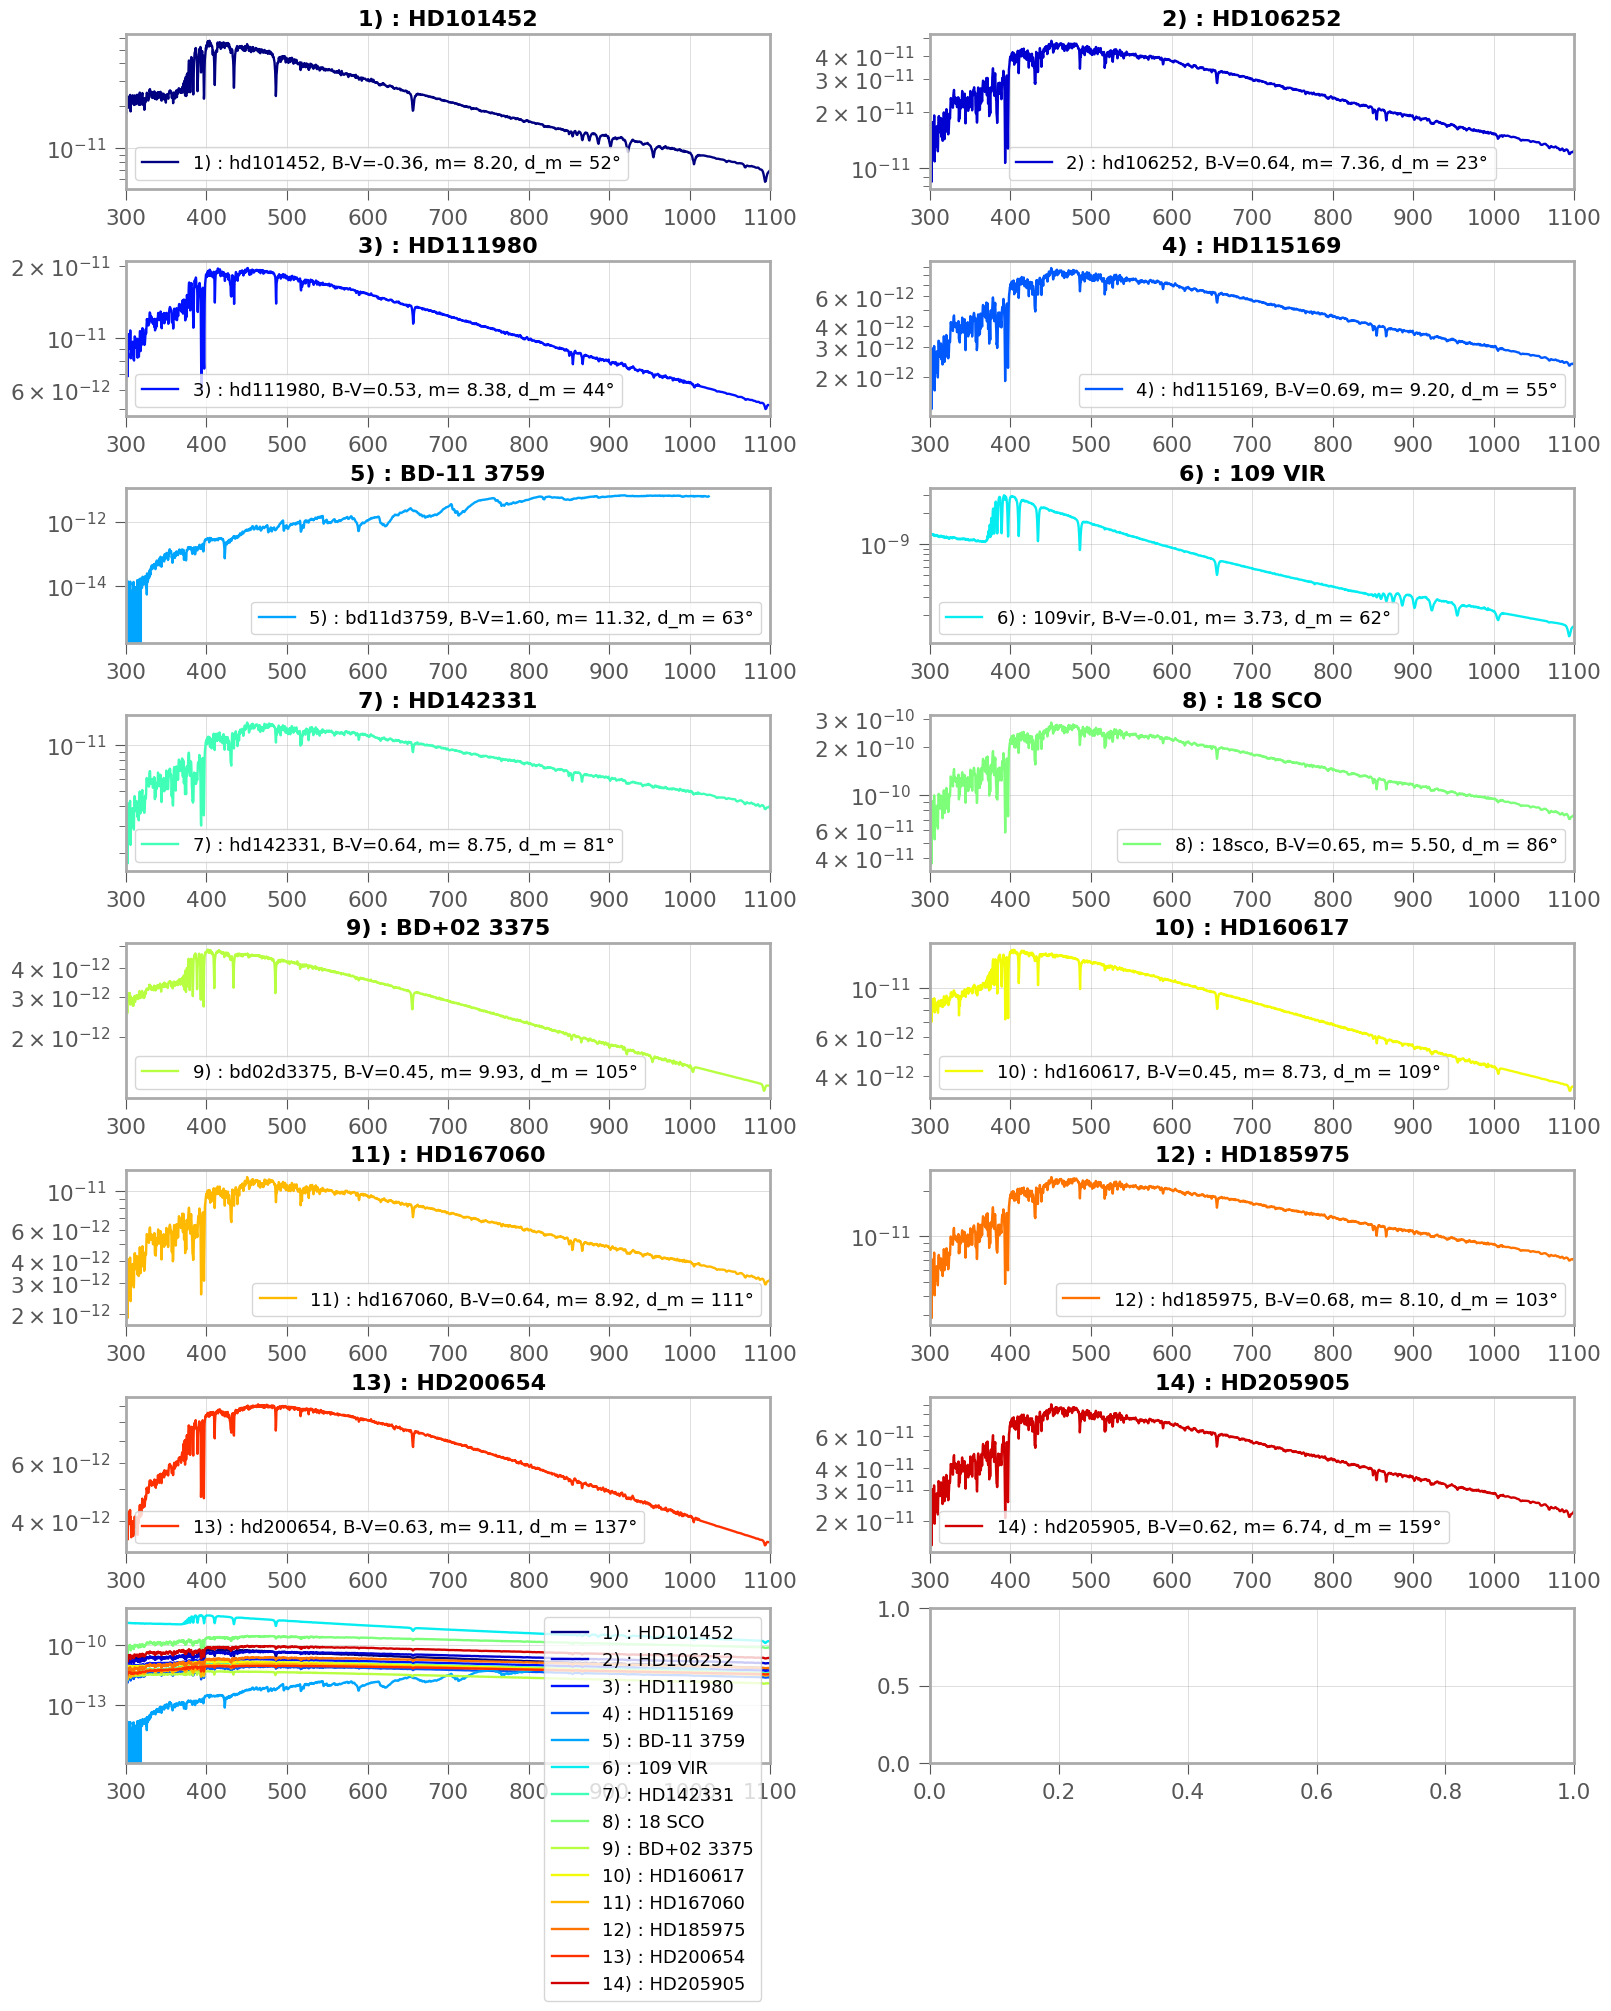

In [105]:
fig, axes= plt.subplots(nrows=nrows,ncols=ncols,sharex=False,figsize=(16,20), layout='constrained')

# loop on selected targets in pandas dataframe t according rank order
all_wl = []
all_fl = []
all_obj= []

for index, ax in enumerate(axes.flat):
    
    if index < NTargets:
    
        # select the good row in pandas dataframe from time ordering
        row = (t[t["rank_tmax"] == index]).iloc[0]
    

        # get its tag
        label = str(index+1) + ") : " + row["tag"]
    
        # rank in all_target_altazs_evening_to_morning table
        target_name = row["Star_name"]
    
        test = is_calspec(target_name)
    
        if test:
        
            c = Calspec(target_name)
            c.get_spectrum_fits_filename()  # download the fits file
            tab = c.get_spectrum_table()  # download and return an Astropy table
            arr = c.get_spectrum_numpy()  # download and return a dictionnary of numpy arrays with units
            #c.plot_spectrum()  # download and plot the spectrum
            
            wl = arr['WAVELENGTH'].to_value()/10.
            fl = arr['FLUX'].to_value()*10.
            
            indexes = np.where(np.logical_and(wl>=XMIN,wl<=XMAX))[0]
            
            wl = wl[indexes]
            fl = fl[indexes]
            ax.plot(wl,fl,"-",color=all_colors[index],label=label)
            ax.set_yscale("log")
            title = f"{index+1}) : {target_name}"
            ax.set_title(title)
            ax.legend()
            ax.set_xlim(XMIN,XMAX)
            
            all_wl.append(wl)
            all_fl.append(fl)
            all_obj.append(title)
        else:
            print(f"{target_name} NOT A CALSPEC")
    else:
        if index == NTargets:
            for j in range(NTargets):
                ax.plot(all_wl[j], all_fl[j],'-',color=all_colors[j],label=all_obj[j] )
            ax.set_yscale("log")
            ax.legend()
            ax.set_xlim(XMIN,XMAX)
#plt.tight_layout()            

Text(0, 0.5, 'FLAM')

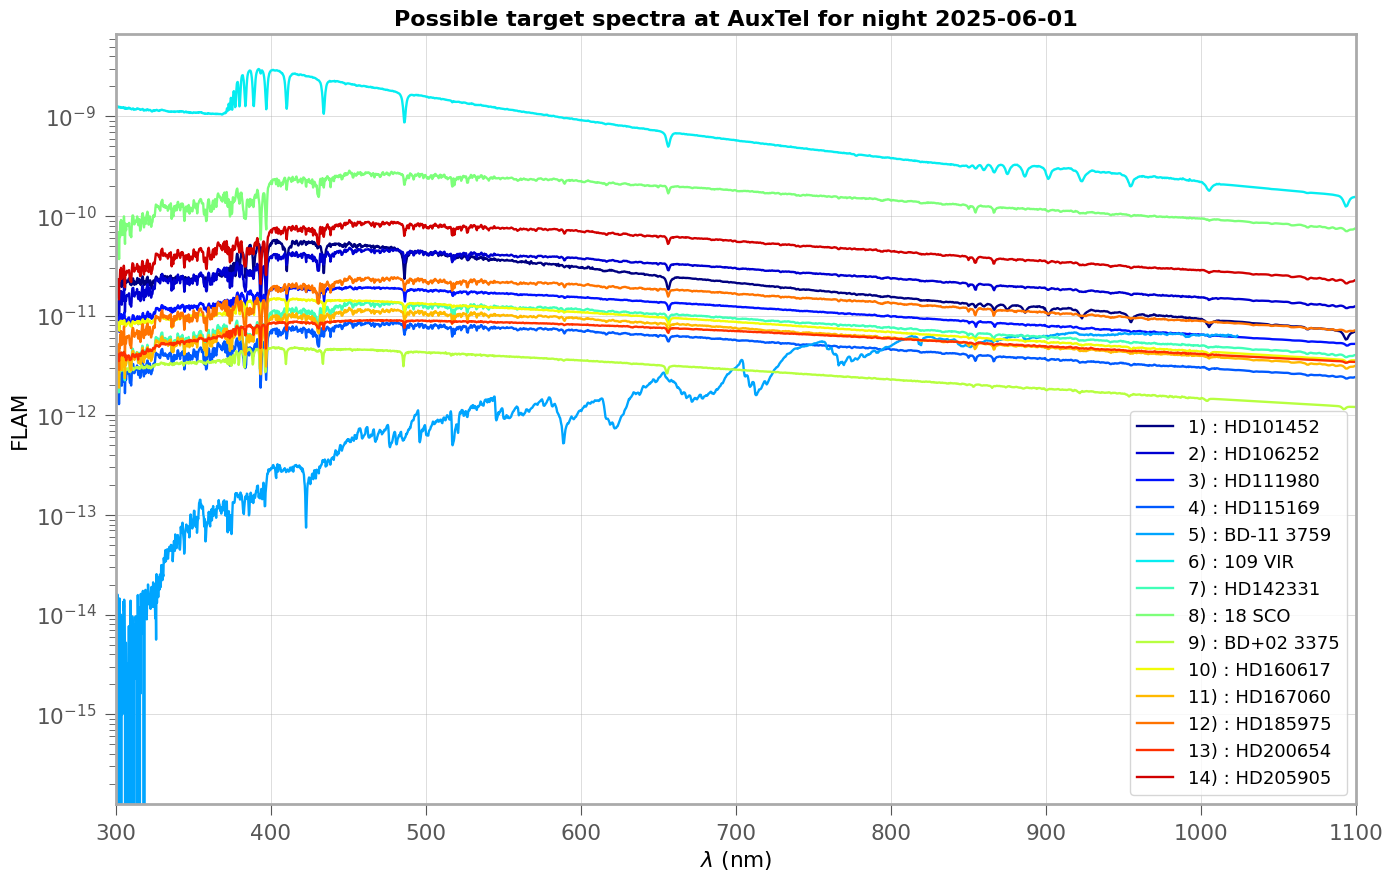

In [106]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,10))

for j in range(NTargets):
    ax.plot(all_wl[j], all_fl[j],'-',color=all_colors[j],label=all_obj[j] )
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlim(XMIN,XMAX)
title = "Possible target spectra at AuxTel for night " + night_obs_str.split(" ")[0]
ax.set_title(title) 
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("FLAM")

## Choose spectra

- **Select by hands the target one want to select**

In [107]:
index_chosen_spectra = np.array([10,12,15]) -1

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/2111314233.py:94: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_90184/2111314233.py:106: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


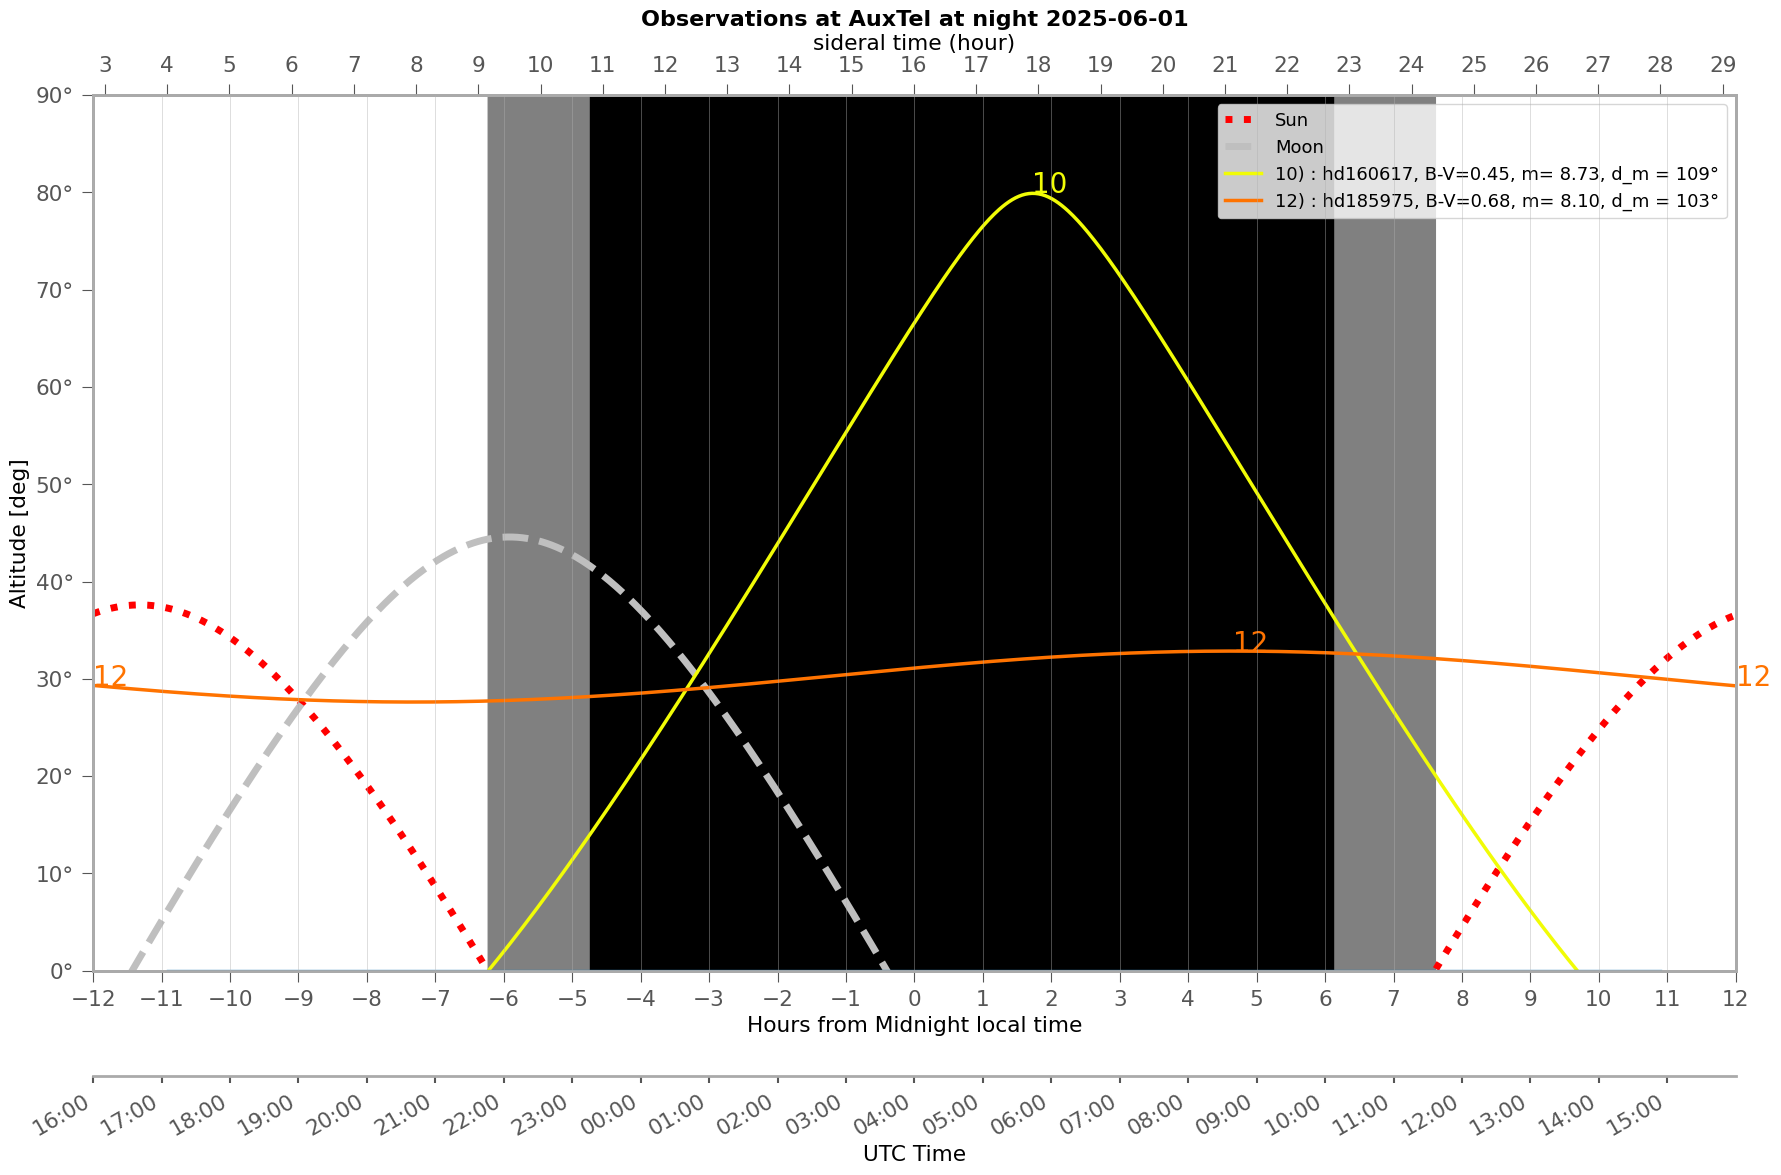

In [108]:
fig = plt.figure(figsize=(18,12),layout="constrained")
ax=fig.add_subplot(1,1,1)


# First Axis : target sky trajectories
# ====================================

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    if index not in index_chosen_spectra:
        continue
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)


#Second axis : Sideral time axis
# ==============================

ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)


# Third horizontal axis : UTC time
# ================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
#fmt = '%m/%d %H:%M'
fmt = '%H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])

ax3.tick_params(which='major', width=1.50, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
# rotation of labels
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.set_xlabel("UTC Time")

plt.tight_layout()

figname="AuxtelStarAlt_CalspecSpectraSelected{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.savefig(figname)
plt.show()